# ScraMF Universal

In [6]:
#import packages for analysis
import scanpy as sc
import pandas as pd
import numpy as np
import os
from matplotlib import rcParams
import seaborn as sb
import matplotlib.pyplot as plt
import anndata as ad
from scipy import sparse
from anndata import AnnData
import time
import random
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import scrublet as scr
import warnings
import pickle
import sys

### Import ScraMF_Universal package

In [2]:
from Classifier import ScraMF_Universal as scu

### The train_model_classifier fuctions trains the models on the training Anndata provided by the user
- The fuction takes as argument the training Anndata
- Returns two models which are subsequently used for the male/female classification of cells 
- It allows the user to train the models on cell-type of their choice and then utilize the user trained models to classify test datasets with the help of scramf_universal function
- The default parameters for epochs, max depth and eta are set for training the models but the user can change it by passing them as arguments of the function
- If the argument predict=True is passed, the function will provide information on how well the models perform when used to predict the sex of the training dataset
- To train the models better and to get an overall idea of how many True Positives, True Negatives, False Positives and False Negatives are predicted by the function, cutoff values from 0.75 to 0.95 are subsequently used and a lineplot is displayed to allow the user to optimize further

#### Training dataset made by combining data from three sources:
- doi: https://doi.org/10.1016/j.immuni.2021.04.003 (MISC)
- doi: https://doi.org/10.1038/s41467-021-27716-4 (COVID)
- doi: https://doi.org/10.1038/s41590-020-0743-0 (LUPUS)

In [3]:
adata_training = sc.read('/home/sparikh/Classifier_data/adata_training_filtered.h5ad')

Initializing
Preparing Training Anndata
Training Models
Training Complete


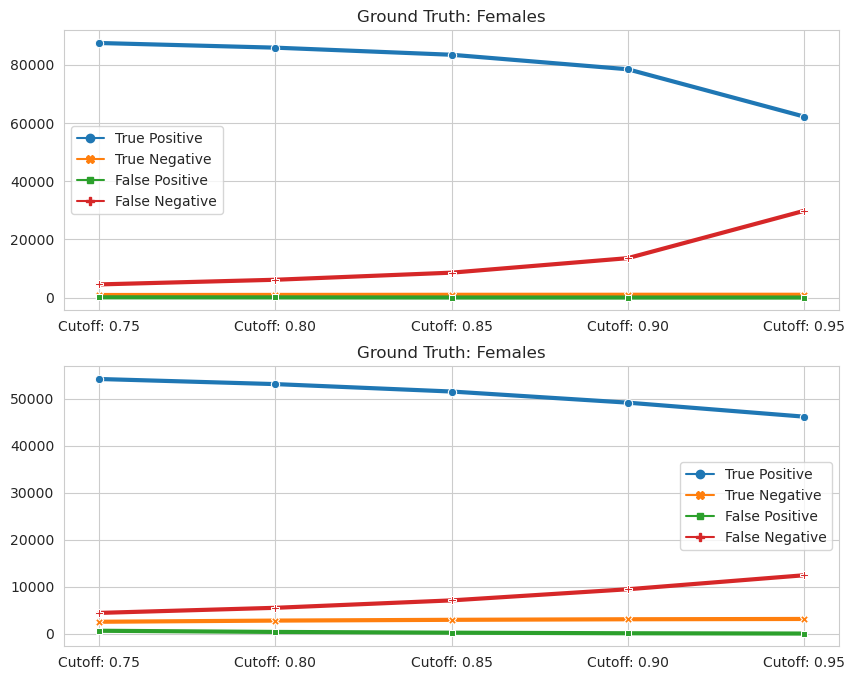

<Figure size 640x480 with 0 Axes>

The accuracy_score for males for universally trained model is 0.9486843382852704
The accuracy_score for females for universally trained model is 0.9896574709183564
--- 5 mins ---


In [5]:
model_softmax, model_softprob = scu.train_model_classifer(adata_training, predict=True)

### Import test Anndata
- Test dataset taken from paper published: https://doi.org/10.1016/j.medj.2021.04.008

In [8]:
adata_test = sc.read('/home/sparikh/Classifier_data/adata_test_kawasaki.h5ad')

### The sex_classifier_universal function utilizes the models trained by the previous function
#### Classifies cells into males and females based on the count matrix obtained from single cell RNA sequencing experiments.
- The function takes as argument the test Anndata and the two models from the model_classifier function 
- The prediction column is appended to the test Anndata obs dataframe.
- If the test Anndata contains male/female sex labels, the function provides the accuracy score
- In case of sex labels being present, the user can set the cutoff value to categorize the classification into: True Positive, True Negative, False Positive and False Negative
- The accuracy score for males and females is calculated
- The function ends with ROC-AUC Curve

Initializing
Preparing Test Adata
Test Anndata Modified For The Model
Sex Prediction Complete
Adding Columns to the Test Anndata
The accuracy_score for males for universally trained model is 0.9313881089000122
The accuracy_score for females for universally trained model is 0.9666758374028475


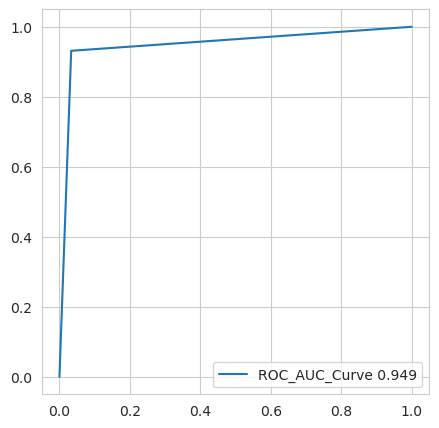

Prediction Completed
--- 0 mins ---


In [9]:
scu.scramf_universal(adata_test, model_softmax, model_softprob, class_prob_cutoff=0.85)

In [7]:
#PCA analysis
sc.pp.pca(adata_test)
#Normalize the data to 10000 reads per cell
sc.pp.normalize_total(adata_test, target_sum=1e4)
#Log tranform the data
sc.pp.log1p(adata_test)

### The misclassified function of the package returns a dataframe and works on **test Anndata with Sex Annotation** 
#### *Cell type annotation is an important part of the function and therefore, the function requires annotated Anndata from the user*

- The function can either work by comparing the sex annotated anndata to the predictions added by the sex_classifier or it can work on the class prediction probability to classify the misclassified cells
- The returned dataframe gives information about the number of correctly and incorrectly classified cells according to the cell type annotation
- The dataframe attempts to explain why certain cells were misclassified, such as if they have low quality, are doublets, or have a high mitochondiral fraction
- The function allows the user to specify custom values for the minimum number of counts, minimum number of genes, and mitochondiral fraction as arguments, rather than using the default values
- It allows the user to set custom values for the cutoff for the class prediction probability

In [8]:
df = scu.misclassified(adata_test, min_ncounts=1100, min_genes=300, min_mtfrac=0.04)

Initializing
(53651, 30)
(53651, 30)
Annotation Complete
Low quality cells detected and dataframe created
--- 2 mins ---


In [9]:
df

,Annotation,Number_Cells,Perc_Total,Perc_Incorrectly_Classified,Number_Cells_Misclass,Num_Doublets,NCells_High_MT_Frac,NCells_Low_Count/Genes,NCells_Explained_Misclass,NCells_Unexplained_Misclass,Perc_Unexplained,Perc_Unexplained_Total_Pop
0,CD4+ Naive T,7838.0,14.611412,0.944118,74.0,0.0,5.0,22.0,22.0,52.0,70.270270,2.751323
1,CD4+ Cytotoxic T,1812.0,3.377887,2.207506,40.0,1.0,5.0,3.0,4.0,36.0,90.000000,1.904762
2,Intermediate B cell,3057.0,5.698786,1.701014,52.0,4.0,5.0,3.0,7.0,45.0,86.538462,2.380952
3,CD14+ Monocyte,5859.0,10.922208,21.505376,1260.0,26.0,5.0,187.0,213.0,1047.0,83.095238,55.396825
4,Naive B cell,11351.0,21.160263,2.863184,325.0,1.0,5.0,31.0,32.0,293.0,90.153846,15.502646
5,CD56-dim Natural Killer,3311.0,6.172287,3.956509,131.0,0.0,5.0,5.0,5.0,126.0,96.183206,6.666667
6,CD4+ Effector Memory T,1322.0,2.464441,0.983359,13.0,1.0,5.0,1.0,2.0,11.0,84.615385,0.582011
7,CD8+ Naive T,6454.0,12.031393,0.480322,31.0,0.0,5.0,5.0,5.0,26.0,83.870968,1.375661
8,CD4+ Central Memory T,8190.0,15.267602,1.343101,110.0,8.0,5.0,26.0,34.0,76.0,69.090909,4.021164
9,gamma-delta T,1080.0,2.013310,1.481481,16.0,0.0,5.0,0.0,0.0,16.0,100.000000,0.846561


### The ambiguously_classified function of the package also returns a dataframe but works on the **test Anndata without Sex annotation**
#### *Cell type annotation is an important part of the function and therefore, the function requires annotated Anndata from the user*

- The function works to identify ambiguously classified cells determined by the custom value set for the cutoff for the class prediction probability specified by the user
- The default cutoff value is set to 0.85
- The returned dataframe is built under the assumption that cells with class probability lower than the cutoff are 'incorrectly' classified and vice versa
- The returned dataframe gives information about the number of 'correctly' and 'incorrectly' classified cells according to the cell type annotation
- The dataframe attempts to explain why certain cells were misclassified, such as if they have low quality, are doublets, or have a high mitochondiral fraction
- The function allows the user to specify custom values for the minimum number of counts, minimum number of genes, and mitochondiral fraction as arguments, rather than using the default values

In [14]:
adata_test.obs.drop('Sex', axis=1, inplace=True)
df_ambiguously_classified = scu.ambiguously_classified(adata_test, class_prob_cutoff=0.85)

Initializing
Low quality cells detected and dataframe created
--- 0 mins ---


In [15]:
df_ambiguously_classified

,Annotation,Number_Cells,Perc_Total,Perc_Incorrectly_Classified,Number_Cells_Misclass,Num_Doublets,NCells_High_MT_Frac,NCells_Low_Count/Genes,NCells_Explained_Misclass,NCells_Unexplained_Misclass,Perc_Unexplained,Perc_Unexplained_Total_Pop
0,CD4+ Naive T,7838.0,14.611412,3.878540,304.0,2.0,5.0,46.0,48.0,256.0,84.210526,4.625113
1,CD4+ Cytotoxic T,1812.0,3.377887,7.505519,136.0,9.0,5.0,4.0,13.0,123.0,90.441176,2.222222
2,Intermediate B cell,3057.0,5.698786,6.280667,192.0,5.0,5.0,10.0,15.0,177.0,92.187500,3.197832
3,CD14+ Monocyte,5859.0,10.922208,38.436593,2252.0,36.0,5.0,268.0,304.0,1948.0,86.500888,35.194219
4,Naive B cell,11351.0,21.160263,10.395560,1180.0,12.0,5.0,88.0,100.0,1080.0,91.525424,19.512195
5,CD56-dim Natural Killer,3311.0,6.172287,25.309574,838.0,7.0,5.0,7.0,14.0,824.0,98.329356,14.887082
6,CD4+ Effector Memory T,1322.0,2.464441,5.143722,68.0,1.0,5.0,3.0,4.0,64.0,94.117647,1.156278
7,CD8+ Naive T,6454.0,12.031393,2.060738,133.0,0.0,5.0,10.0,10.0,123.0,92.481203,2.222222
8,CD4+ Central Memory T,8190.0,15.267602,5.958486,488.0,18.0,5.0,44.0,62.0,426.0,87.295082,7.696477
9,gamma-delta T,1080.0,2.013310,5.833333,63.0,7.0,5.0,2.0,9.0,54.0,85.714286,0.975610


### The plot_avg_gene_expression function plots the average gene expression of highly expressed genes in Groups
- The heatmap plots the average gene expression of highly expressed genes in all four groups: Correct Females and Incorrect Females, Correct Males and Incorrect Males
- The genes that show highly expression are calculated separately for males and females across correctly classified and incorrectly classified cells
- The function helps in understanding how the classifier classifies the cells based on the genes expressed in different cell types

Computing
Genes Identified
Dataframes created
Plotting


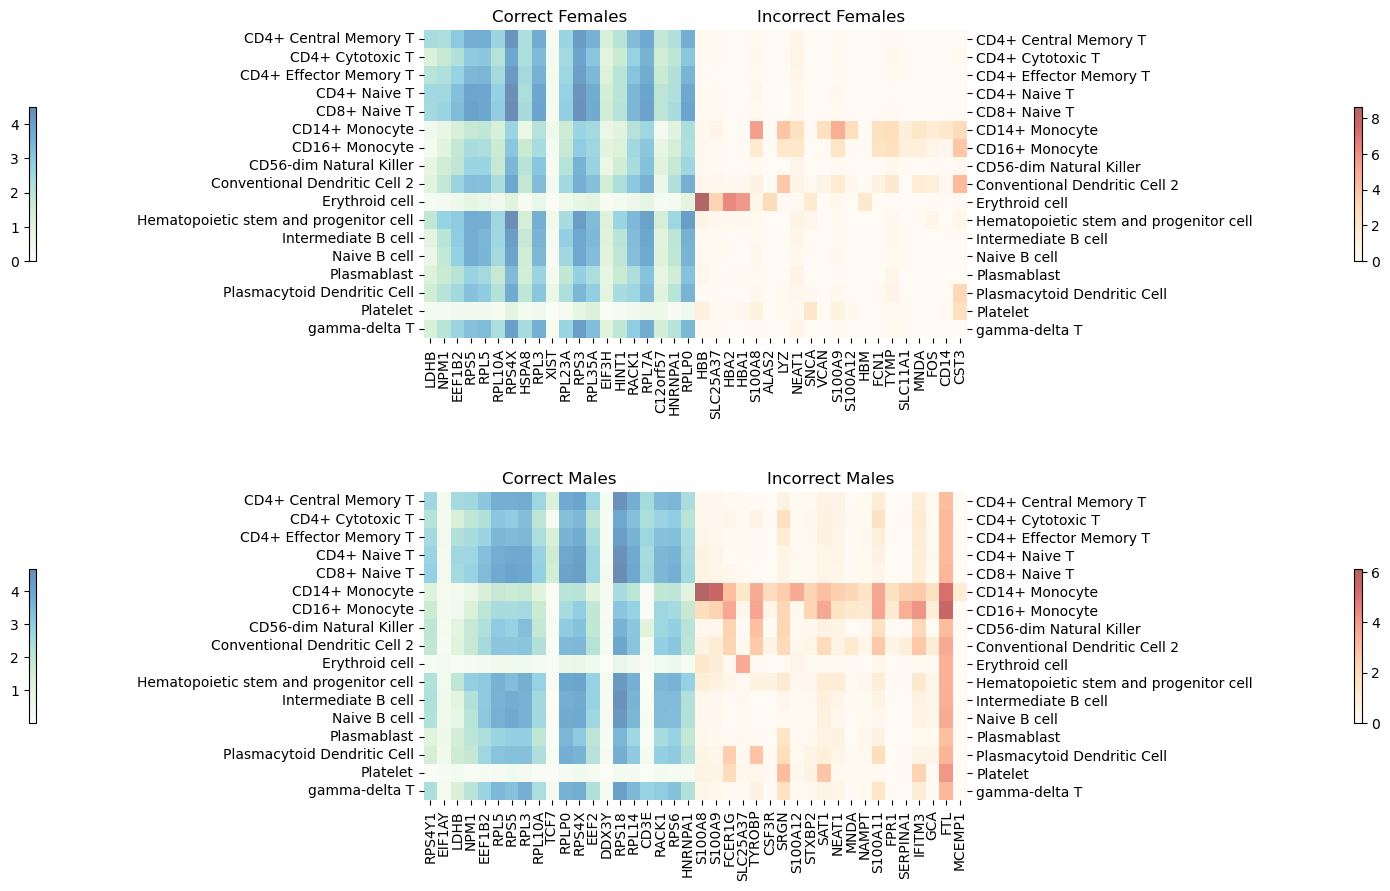

--- 19 sec ---


In [15]:
plots = scu.plot_avg_gene_expression(adata_test)

- The 20 highly expressed genes for all groups are first stored in a list
- The mean expression of each gene is calculated across the respective Anndata and stored in a datframe
- The dataframe is then used to plot the heatmap which is shown above
- The heatmap shows which genes are expressed in correctly and incorrectly classified groups and the level of expression associated with them, giving a general understanding of this relationship